Raoul Island Lake Monitoring Data - Display of 'Recent' Data
--

The GeoNet wiki provides automatically updating plots to show the lake monitoring data at Raoul Island -
- http://images.geonet.org.nz/volcano/ki/glkz/40/drum.png
- http://images.geonet.org.nz/volcano/ki/glkz/80/drum.png
- http://images.geonet.org.nz/volcano/ki/glkz/81/drum.png.

The scaling of these plots makes it difficult to see small changes, and the plots are not of sufficient quality for use outside GNS.

The raw data are stored as mini-seed files as part of GeoNet's seismic data archive. These data can be accessed using GeoNet's FDSN web servers http://www.geonet.org.nz/data/tools/FDSN. Response information can be retrieved with the raw data, which allows raw observations to be converted to units of degrees celcius and metres, respectively. The use of mini-seed files, the FDSN server, and response information means that some do not have the technical knowledge to access the data.

This notebook provides a simple method to access and plot the monitorng data. The plots are of sufficient quality to use outside GNS for VABs, DOC staff training, etc.

In [77]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [78]:
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client

import matplotlib.pyplot as plt

%matplotlib inline

In [79]:
#GeoNet's FDSN web servers
arc_client = 'http://service.geonet.org.nz'
nrt_client = 'http://beta-service-nrt.geonet.org.nz'

In [80]:
#function to get a stream from both FDSN clients
def waveboth(date1, date2, net, sta, loc, cmp):
    #get data from a FDSN web server for days date1 to date2 inclusive
    global stnrt, starc
    #   global starc
    time1 = UTCDateTime(date1)
    time2 = UTCDateTime(date2)

    #nrt client
    try:
        client = Client(nrt_client)
        stnrt = client.get_waveforms(net, sta, loc, cmp, time1, time2, attach_response=True)
        print ('nrt client successful')
    except:
        print ('nrt client not successful')

    #arc client
    try:
        client = Client(arc_client)
        starc = client.get_waveforms(net, sta, loc, cmp, time1, time2, attach_response=True)
        print ('arc client successful')
    except:
        print ('arc client not successful')

In [81]:
#channel data for fdsn
net = 'NZ'
sta = 'GLKZ'

<span style="color:red">**Change this to select number of days of data to plot**</span>

In [82]:
#get data upto how many days before now
ndays = 60

In [83]:
#channel specific parameters
chan = [{'loc':'80', 'cmp':'LKO', 'subject':'green lake temperature', 'trace':'glt'},
        {'loc':'81', 'cmp':'LKO', 'subject':'marker bay temperature', 'trace':'mbt'},
        {'loc':'40', 'cmp':'LTH', 'subject':'green lake level', 'trace':'gll'}]

In [84]:
def make_trace(n):
    global st
    cmp = chan[n]['cmp']
    loc = chan[n]['loc']
    subject = chan[n]['subject']
    print (cmp, loc, subject)
    
    #last date to process = now
    dt2 = UTCDateTime()
    dt2str = dt2.strftime('%Y-%m-%d')
    
    #find first date to process
    dt1 = dt2 - (ndays * 86400)
    dt1str = dt1.date.strftime('%Y-%m-%d')
    
    print ('first date to process '+dt1str)
    print ('last date to process '+dt2str)

    waveboth(dt1, dt2, net, sta, loc, cmp)
    
    st = stnrt
    if ndays > 8: #so both FDSN servers should have useful data
        st += starc
    #some traces in stream possibly might not have response information, find these
    remlist = []
    for n in range(len(st)):
        try:
            st[n].remove_sensitivity()
        except:
            print (st[n],' response removal failed')
            remlist.append(n)
    #then remove them from the stream, if remlist empty nothing done
    for rem in remlist:
        st.remove(st[rem])
    st.merge(fill_value = 'interpolate')
    tr = st[0]
    print()
    return(tr)

**Create traces for recent data , decimate to 1 minute sampling**

In [85]:
#glt
glt = make_trace(0)
glt.decimate(factor=10, strict_length=False, no_filter=True)
glt.decimate(factor=6, strict_length=False, no_filter=True)

#mbt
mbt = make_trace(1)
mbt.decimate(factor=10, strict_length=False, no_filter=True)
mbt.decimate(factor=6, strict_length=False, no_filter=True)

#gll
gll = make_trace(2)
gll.decimate(factor=10, strict_length=False, no_filter=True)
gll.decimate(factor=6, strict_length=False, no_filter=True)

LKO 80 green lake temperature
first date to process 2019-08-25
last date to process 2019-10-24
nrt client successful
arc client successful

LKO 81 marker bay temperature
first date to process 2019-08-25
last date to process 2019-10-24
nrt client successful
arc client successful

LTH 40 green lake level
first date to process 2019-08-25
last date to process 2019-10-24
nrt client successful
arc client successful
NZ.GLKZ.40.LTH | 2019-09-21T00:50:32.071800Z - 2019-09-21T01:03:19.071800Z | 1.0 Hz, 768 samples  response removal failed



NZ.GLKZ.40.LTH | 2019-08-25T00:51:53.071800Z - 2019-10-24T00:51:53.071800Z | 60.0 s, 86401 samples

**Plot data**

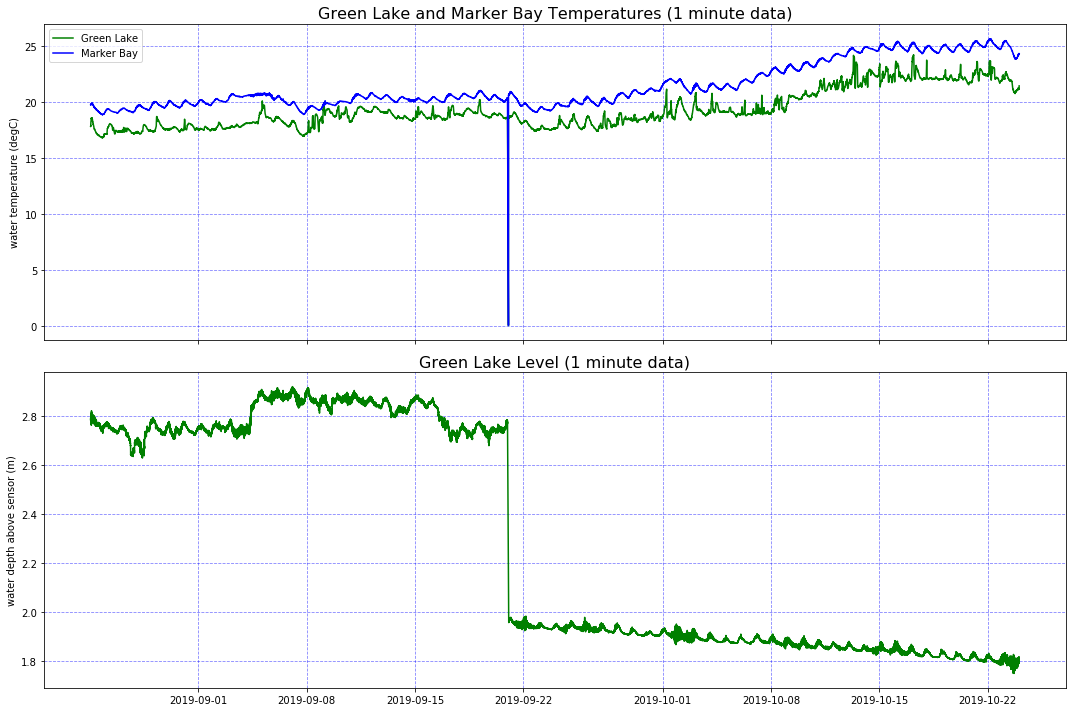

In [86]:
fig, (temps, level) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(15,10))

temps.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
temps.plot(glt.times("matplotlib"), glt.data, 'green', label='Green Lake')
temps.plot(mbt.times("matplotlib"), mbt.data, 'blue', label='Marker Bay')
temps.set_ylabel('water temperature (degC)')
temps.legend(loc='best')
temps.set_title('Green Lake and Marker Bay Temperatures (1 minute data)', fontsize=16)
temps.xaxis_date()

level.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
level.plot(gll.times("matplotlib"), gll.data, 'green')
level.set_ylabel('water depth above sensor (m)')
level.set_title('Green Lake Level (1 minute data)', fontsize=16)

plt.tight_layout()
fig.savefig('raoul_lakes_recent.png', dpi=200)